In [1]:
import pickle
import numpy as np
import pomegranate as pom
import sys
sys.path.append('../src')
from visualization import draw_timeline_with_states, save_png, draw_distribution

from variables import toys_dict, tasks, toys_list
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.utils import check_random_state

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd

from pathlib import Path
import os 
import importlib
from collections import OrderedDict

13


### Params 

In [8]:
n_features = 4

### Helpers

In [9]:
def convert_to_int(list_to_convert):
    converted_list = []
    for i in list_to_convert:
        i = i.astype(int)
        converted_list.append(i)
    return converted_list

def convert_to_list_seqs(big_seq, len_array):
    big_seq_to_slice = big_seq.copy()
    list_of_seqs = []
    
    for k in len_array:
        list_of_seqs.append(big_seq_to_slice[:k])
        big_seq_to_slice = big_seq_to_slice[k:]
    return list_of_seqs

def save_csv(df, file_path, file_name):
    if not os.path.exists(file_path):
        file_path.mkdir(parents=True)
    save_path = file_path / file_name
    df.to_csv(save_path)

### Load data

In [2]:
with open('../data/interim/20210701_feature_engineering.pickle', 'rb') as f:
    feature_dict = pickle.load(f)

with open('../data/interim/20210701_label.pickle', 'rb') as f:
    labels_dict = pickle.load(f)

### All tasks

In [5]:
# task_specific_feature = feature_dict['MPS']
interval_length = 2  # every 2 minutes
no_ops_threshold = 5/60
new_toy_threshold = 2

shift_time_list = np.arange(0, interval_length, .5)

len_list = []
n_features = 4

input_list = np.empty((0, n_features))
input_list_ = np.empty((0, n_features))
for task in tasks:
    for subj, shifted_df_dict in feature_dict[task].items():
        for shift_time, feature_vector in shifted_df_dict.items():
            # print(feature_vector)
            input_list = np.vstack((input_list, feature_vector))
            input_list_ = np.concatenate((input_list_, feature_vector))

            len_list.append(len(feature_vector))

In [6]:
all_labels = []
for task in tasks:
    for subj, shifted_sequence in labels_dict[task].items():
        for shift_time, label in shifted_sequence.items(): 
            all_labels.append(label)

In [42]:
input_list.shape


(2423, 4)

(array([520., 519., 617., 350., 235.,  83.,  56.,  23.,  16.,   4.]),
 array([ 0. ,  5.5, 11. , 16.5, 22. , 27.5, 33. , 38.5, 44. , 49.5, 55. ]),
 <BarContainer object of 10 artists>)

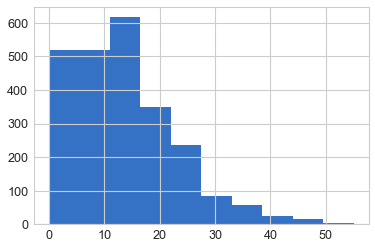

In [7]:
plt.hist(input_list[:,0])

(array([116., 278., 692.,   0., 638., 446.,   0., 188.,  62.,   3.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

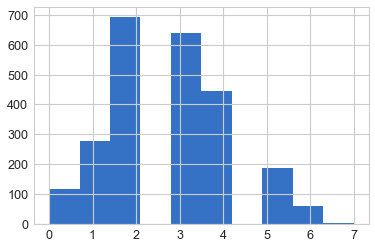

In [27]:
plt.hist(input_list[:,1])

In [32]:
np.unique(input_list[:,1])

array([0., 1., 2., 3., 4., 5., 6., 7.])

(array([366., 553., 690.,   0., 490., 235.,   0.,  72.,  16.,   1.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

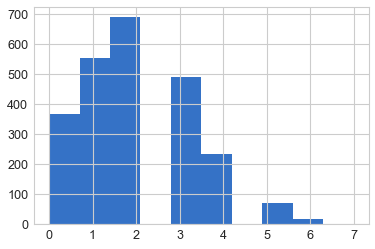

In [28]:
plt.hist(input_list[:,2])

In [31]:
np.unique(input_list[:,2])

array([0., 1., 2., 3., 4., 5., 6., 7.])

(array([183., 129., 205., 298., 351., 320., 291., 262., 166., 218.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

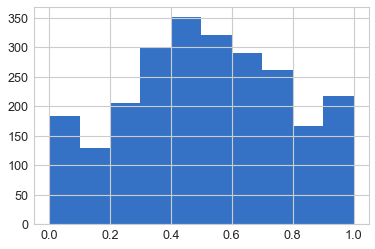

In [29]:
plt.hist(input_list[:,3])

In [30]:
# plt.hist(input_list[:,4])

### Discretization

In [13]:
toy_switch_bins = [0,10,20,30]
n_bin_ep_rate = range(len(toy_switch_bins))
discretized_toy_switch_rate = np.digitize(input_list[:,0], toy_switch_bins, right = False)
# discretized_toy_switch_rate = discretized_ep_rate -1
_, counts = np.unique(discretized_toy_switch_rate, return_counts = True) 
heights = counts/counts.sum()
fig = px.bar(x = n_bin_ep_rate, y = heights, text=counts)
# fig.update_layout(width=800, height=800, 
#                         title_text='Distribution of discretized rate of toy switch',
#                      xaxis = dict(
#                     tickmode = 'array',
#                     tickvals = ep_rate_dict[window_size],
#                 ))
# fig.show()

In [14]:
discretized_n_toys = np.where(input_list[:,1] > 4, 4, input_list[:,1])
# discretized_toy_switch_rate = discretized_ep_rate -1
n_toy_unique, counts = np.unique(discretized_n_toys, return_counts = True) 
heights = counts/counts.sum()
fig = px.bar(x = n_toy_unique, y = heights, text=counts)
# fig.update_layout(width=800, height=800, 
#                         title_text='Distribution of discretized rate of toy switch',
#                      xaxis = dict(
#                     tickmode = 'array',
#                     tickvals = ep_rate_dict[window_size],
#                 ))
# fig.show()

In [15]:
discretized_n_new_toys = np.where(input_list[:,2] > 4, 4, input_list[:,2])
# discretized_toy_switch_rate = discretized_ep_rate -1
n_new_toys_unique, counts = np.unique(discretized_n_new_toys, return_counts = True) 
heights = counts/counts.sum()
fig = px.bar(x = n_new_toys_unique, y = heights, text=counts)
# fig.update_layout(width=800, height=800, 
#                         title_text='Distribution of discretized rate of toy switch',
#                      xaxis = dict(
#                     tickmode = 'array',
#                     tickvals = ep_rate_dict[window_size],
#                 ))
# fig.show()

In [16]:
fav_toy_bin = [0, .2, .4, .6, .8]
n_bins_fav_toy = len(fav_toy_bin)

fav_toy_rate_discretized = np.digitize(input_list[:,3].copy(), fav_toy_bin, right = False)
# dominant_toy_rate_discretized = dominant_toy_rate_discretized - 1
_, counts = np.unique(fav_toy_rate_discretized, return_counts = True) 
heights = counts/counts.sum()
fig = px.bar(x = fav_toy_bin, y = heights, text=counts)
# fig.update_layout(width=800, height=800, 
#                         title_text='Distribution of discretized rate of dom toy ratio',
#                      xaxis = dict(
#                     tickmode = 'array',
#                     tickvals =  fav_toy_bin,
#                 ))
# fig.show()

In [12]:
n_bins_toy_iou = 5
iou_discretizer = KBinsDiscretizer(n_bins_toy_iou, encode = 'ordinal', strategy = 'uniform')
toy_iou_discretized = iou_discretizer.fit_transform(input_list[:,4].copy().reshape((-1,1)))

_, counts = np.unique(toy_iou_discretized, return_counts = True) 
heights = counts/counts.sum()
fig = px.bar(x = iou_discretizer.bin_edges_[0][1:], y = heights, text=counts)
# fig.show()


IndexError: index 4 is out of bounds for axis 1 with size 4

In [17]:
discretized_input_list = np.hstack((discretized_toy_switch_rate.reshape((-1,1)),\
                                    discretized_n_toys.reshape((-1,1)),\
                                    discretized_n_new_toys.reshape((-1,1)),\
                                    fav_toy_rate_discretized.reshape((-1,1))))
                                    # toy_iou_discretized.reshape((-1,1))))

In [18]:
list_seq = convert_to_list_seqs(discretized_input_list, len_list)
list_seq = convert_to_int(list_seq)

In [18]:
len(list_seq)

624

In [19]:
def discritize_with_sub(feature, threshold = 4):
    """
    Cap out the values at the higher end. Used for 'n_toys' and 'n_new_toys' features
    """
    return np.where(feature > threshold, threshold, feature)

def discritize_with_bins(feature, bins_):
    """
    Group values into different bins. Used for 'n_toy_switches" and 'fav_toy_ratio'
    """
    return np.digitize(feature, bins_, right = False)

def discritize_toy_iou(feature, discretizer):
    return iou_discretizer.transform(feature).reshape((-1,))

### Fit model

In [20]:
def create_independent_dist(feature, seed):
    unique_val = np.unique(feature)
    init_dict = {}
    random_state = check_random_state(seed)
    init_prob = random_state.rand(len(unique_val),1)
    init_prob = init_prob/init_prob.sum()
    
    for idx, i in enumerate(unique_val):
        init_dict[int(i)] = init_prob[idx].item()
    return pom.DiscreteDistribution(init_dict)

def create_dist_for_states(n_states, feature_list, seed):
    distributions = []
    i = 0
    for _ in range(n_states):
        dist_list = []
        for f in feature_list:
            dist = create_independent_dist(f, i)
            i += 1
            dist_list.append(dist)
        distributions.append(pom.IndependentComponentsDistribution(dist_list))
    return distributions

def init_hmm(n_components, feature_list, seed):
    random_state_trans = check_random_state(seed**seed)
    transitions = random_state_trans.rand(n_components, n_components)
    transitions = transitions/transitions.sum()
    
    random_state_start = check_random_state(seed**2)
    starts = random_state_start.rand(n_components)
    starts = starts/starts.sum()
    distributions = create_dist_for_states(n_components, feature_list, seed)
    model = pom.HiddenMarkovModel.from_matrix(transitions, distributions, starts)   
    return model

In [21]:
n_states = 5
seed = 1

In [22]:
model = init_hmm(n_states, discretized_input_list.T, seed)
model.bake()
model.fit(list_seq, labels = all_labels)
# model_file_name = 'model_'+str(n_bin_ep_rate)+str(n_bin_toy_rate)+str(n_bin_new_toy_rate)+str(n_bin_dom_toy_ratio)+str(n_bin_toy_iou)+'_'+str(n_components)+'_states.pickle'
# model_file_path = Path('../data/interim/hmm/20200825/discretized/1.5s_new_toy')/model_file_name
# with open(model_file_path, 'wb+') as f:
#     pickle.dump(model, f)

                    "3" : 0.0,
                                    "4" : 0.0
                                }
                            ],
                            "frozen" : false
                        },
                        {
                            "class" : "Distribution",
                            "dtype" : "int",
                            "name" : "DiscreteDistribution",
                            "parameters" : [
                                {
                                    "0" : 1.0,
                                    "1" : 2.3884999512025683e-73,
                                    "2" : 0.0,
                                    "3" : 0.0,
                                    "4" : 0.0
                                }
                            ],
                            "frozen" : false
                        },
                        {
                            "class" : "Distribution",
                            "dtype" : "int",
      

In [23]:
model_file_path = Path('../models/hmm/20210708/'+str(n_states)+'_states.pickle')
with open(model_file_path, 'wb+') as f:
    pickle.dump(model, f)

In [24]:
def save_csv(df, file_path, file_name):
    if not os.path.exists(file_path):
        file_path.mkdir(parents=True)
    save_path = file_path / file_name
    df.to_csv(save_path)
                
data = []

index_list = [[],[]]


features_obs_dict = {0: len(toy_switch_bins) , 1: 5, 2: 5, 3: 5, 4:5}

for i in range(n_features):
    single_list = np.empty((features_obs_dict[i], n_states))
    for state_idx, state_i in enumerate(range(n_states)):
        observation_dict = model.states[state_i].distribution.parameters[0][i].parameters[0]
        for idx,k in enumerate(observation_dict.keys()):
            single_list[idx, state_idx] = np.round(observation_dict[k], 2)
    index_list[0].extend([i]*len(observation_dict.keys()))
    index_list[1].extend([i for i in observation_dict.keys()])

    data.extend(single_list)

tuples = list(zip(*index_list))
index = pd.MultiIndex.from_tuples(tuples, names=['feature', 'observation'])
df = pd.DataFrame(data, index = index, columns = ['state '+str(i) for i in range(n_states)])
file_path = Path('/scratch/mom_no_mom/reports/20210708/')
file_name = 'mean_'+str(n_states)+"_seed_"+str(seed)+".csv"
# print(np.array(data))
save_csv(df, file_path, file_name)

In [33]:
# features = ['# toy switches', '# toys', '# new toys', 'fav toy ratio', 'toy iou']
# df = pd.DataFrame(data = np.concatenate((model.transmat_, model.startprob_.reshape((1,n_states)))), index = ["State " + str(i) for i in range(n_states)]+["Init_prob"], columns = ["State " + str(i) for i in range(n_states)])
# # file_path = Path('~/Documents/mcs_handrail/reports/continuous_hmm/hmmlearn')
# file_name = 'transmat_all_tasks'+str(n_states)+'_20210705.csv'
# save_csv(df, file_path, file_name)

trans_matrix = pd.DataFrame(np.round(model.dense_transition_matrix()[:n_states+1,:n_states],2))
file_name = 'trans_matrix_'+str(n_states)+"_seed_"+str(seed)+'.csv'

save_csv(trans_matrix, file_path, file_name)

#### transition matrix

In [23]:
i = 0
input_dict = {}
for task in tasks:
    if task not in input_dict.keys():
        input_dict[task] = {}

    for subj, shifted_df_dict in feature_dict[task].items():
        if subj not in input_dict[task].keys():
            input_dict[task][subj] = {}


        for shift_time, feature_vector in shifted_df_dict.items():
            input_dict[task][subj][shift_time] = list_seq[i]
            i += 1

In [24]:
total_log_prob = 0
log_prob_list = []
pred_dict = {}
proba_dict = {}
all_proba_dict = {}

for task in tasks:
    if task not in pred_dict.keys():
        pred_dict[task] = {}
        proba_dict[task] = {}
        all_proba_dict[task] = {}

    for subj, shifted_dict in input_dict[task].items():
        if subj not in pred_dict[task].keys():
            pred_dict[task][subj] = {}
            proba_dict[task][subj] = {}
            all_proba_dict[task][subj] = {}

        for shift_time, feature_vector in shifted_dict.items():
            pred_dict[task][subj][shift_time] = model.predict(feature_vector)
            proba_dict[task][subj][shift_time] = np.amax(model.predict_proba(feature_vector), axis = 1)
            log_prob = model.log_probability(feature_vector)
            all_proba_dict[task][subj][shift_time] = model.predict_proba(feature_vector)
            

            log_prob_list.append(log_prob)
print(np.mean(log_prob_list))

-18.172941430274047


In [124]:
with open('../data/interim/20210709_5_states_prediction_all_prob.pickle', 'wb+') as f:
    pickle.dump(all_proba_dict, f)


In [20]:
pred_dict[task][subj][shift_time]

[1, 1, 3, 0]

In [38]:
for task in tasks:
    trans_matrix = np.zeros((n_states, n_states))
    for subj, shifted_dict in pred_dict[task].items():    
        for shift_time, feature in shifted_dict.items():
            # print(feature)
            for idx, state in enumerate(feature[:-1]):
                # if state != feature[idx + 1]:
                trans_matrix[state][feature[idx + 1]] += 1

    row_sum = trans_matrix.sum(axis=1)
    normalized_trans_matrix = trans_matrix/row_sum[:, np.newaxis]
    # print(np.round(normalized_trans_matrix,3))
    # print(np.sum(normalized_trans_matrix, axis = 1))

    # features = ['front leg', 'back leg', 'front hand', 'back hand']
    df = pd.DataFrame(data = np.round(normalized_trans_matrix,3), index = ["State " + str(i) for i in range(n_states)], columns = ["State " + str(i) for i in range(n_states)])
    # file_path = Path('~/Documents/mcs_handrail/reports/continuous_hmm/hmmlearn')
    file_path = Path('/scratch/mom_no_mom/reports/20210708/')

    file_name = 'transmat_'+str(task)+'_frames_'+str(n_states)+'.csv'
    save_csv(df, file_path, file_name)

/scratch/lehoang_python36/lib64/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in true_divide



### K-fold crossval

In [47]:
from sklearn.model_selection import KFold

list_of_feature = []
for task in tasks:
    for subj, shifted_df_dict in feature_dict[task].items():
        for shift_time, feature_vector in shifted_df_dict.items():
            list_of_feature.append(feature_vector)

In [92]:
kf = KFold(n_splits = 5)
for train_index, test_index in kf.split(list_of_feature):
    # print(train_index.tolist(), len(test_index))
    train_trials = np.array(list_of_feature)[train_index]
    test_trials = np.array(list_of_feature)[test_index]

    len_train = [len(i) for i in train_trials]
    train_input = np.concatenate(train_trials)

    train_input[:,0] = discritize_with_bins(train_input[:,0], bins_ = [0,10,20,30]) 
    train_input[:,1] = discritize_with_sub(train_input[:,1]) 
    train_input[:,2] = discritize_with_sub(train_input[:,2]) 
    train_input[:,3] = discritize_with_bins(train_input[:,3], bins_ =  [0, .2, .4, .6, .8]) 
    train_input[:,4] = discritize_toy_iou(train_input[:,4].reshape((-1,1)), iou_discretizer) 

    train_seq = convert_to_list_seqs(train_input, len_train)
    train_seq = convert_to_int(train_seq)

    len_test = [len(i) for i in test_trials]
    test_input = np.concatenate(test_trials)

    test_input[:,0] = discritize_with_bins(test_input[:,0], bins_ = [0,10,20,30]) 
    test_input[:,1] = discritize_with_sub(test_input[:,1]) 
    test_input[:,2] = discritize_with_sub(test_input[:,2]) 
    test_input[:,3] = discritize_with_bins(test_input[:,3], bins_ =  [0, .2, .4, .6, .8]) 
    test_input[:,4] = discritize_toy_iou(test_input[:,4].reshape((-1,1)), iou_discretizer) 
    
    test_seq = convert_to_list_seqs(test_input, len_test)
    test_seq = convert_to_int(test_seq)

    print(n_states)

    model = init_hmm(n_states, train_input.T, seed)
    model.bake()
    model.fit(train_seq)

    score_ = []
    for seq in test_seq:
        log_prob = model.log_probability(seq)
        if log_prob != -np.inf:
            score_.append(log_prob)
    print(np.mean(score_))

6
/scratch/lehoang_python36/lib64/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/scratch/lehoang_python36/lib64/python3.6/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

-24.10542593139329
6
/scratch/lehoang_python36/lib64/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to d

## For each infant, merge all 4 sessions into one

In [25]:
subj_dict = {}
len_dict = {}

for task in tasks:
    for subj, shifted_df_dict in feature_dict[task].items():
        if subj not in subj_dict.keys():
            subj_dict[subj] = {}
            len_dict[subj] = 0

        for shift_time, feature_vector in shifted_df_dict.items():
            if shift_time not in subj_dict[subj].keys():
                subj_dict[subj][shift_time] = np.empty((0, n_features))

            subj_dict[subj][shift_time] = np.vstack((subj_dict[subj][shift_time], np.array(feature_vector)))

            len_dict[subj] += len(subj_dict[subj][shift_time])

## Visualization

In [7]:
with open('../data/interim/20210701_clean_data_for_feature_engineering.pickle', 'rb') as f:
    task_to_storing_dict = pickle.load(f)

with open('../data/interim/20210701_feature_engineering_time_arr.pickle', 'rb') as f:
    time_arr_dict = pickle.load(f)

In [128]:
# importlib.reload(visualization)
importlib.reload(sys.modules['visualization'])
from visualization import draw_timeline_with_states, save_png, draw_distribution

In [20]:
for task in tasks:
    for subj, shifted_dict in pred_dict[task].items():  
        df = task_to_storing_dict[task][subj].reset_index()
        for shift_time, pred_state_list in shifted_dict.items():
            time_list = time_arr_dict[task][subj][int(shift_time)]
            if len(time_list) > 0 and len(pred_state_list) > 0 and shift_time == 0:
                print(len(time_list), len(pred_state_list) > 0)
                fig = draw_timeline_with_states(subj, df, pred_state_list, time_list, shift_time, show=False)

                save_png(fig, '../figures/hmm/20210709/'+str(n_states)+'_states/'+task+'/'+str(subj)+".png", 1600, 800)
            

NameError: name 'pred_dict' is not defined

### Compare the distribution for task specific 

In [4]:
state_name_dict = OrderedDict({0: "No_toys", 3: "F+", 2: "F",  1: "E", 4:"E+"})
feature_names = ["# toys switches", "# toys", "# new toys", 'fav toy ratio']

In [32]:
x_ticks_dict = {0: ["[0, 10)", '[10, 20)', '[20, 30)', '[30+'], 1: ['0', '1', '2', '3', '4+'], 2: ['0', '1', '2', '3', '4+'], 3: ["[0, .2)", '[.2, .4)', '[.4, .6)', '[.6, .8)', '[.8, 1]']}


In [26]:
flatten_pred_dict = {}
flatten_pred = []
for task in tasks:
    flatten_pred_dict[task] = []
    task_specific_pred_dict = pred_dict[task]
    for subj, subj_dict in task_specific_pred_dict.items():
        for shift_time, pred in subj_dict.items():
            flatten_pred_dict[task].extend(pred)
            flatten_pred.extend(pred)

In [27]:
task_len = [len(flatten_pred_dict[task]) for task in tasks]

In [28]:
task_specific_input = convert_to_list_seqs(discretized_input_list, task_len)
task_specific_input_dict = {}
for i, task in enumerate(tasks):
    task_specific_input_dict[task] = task_specific_input[i]

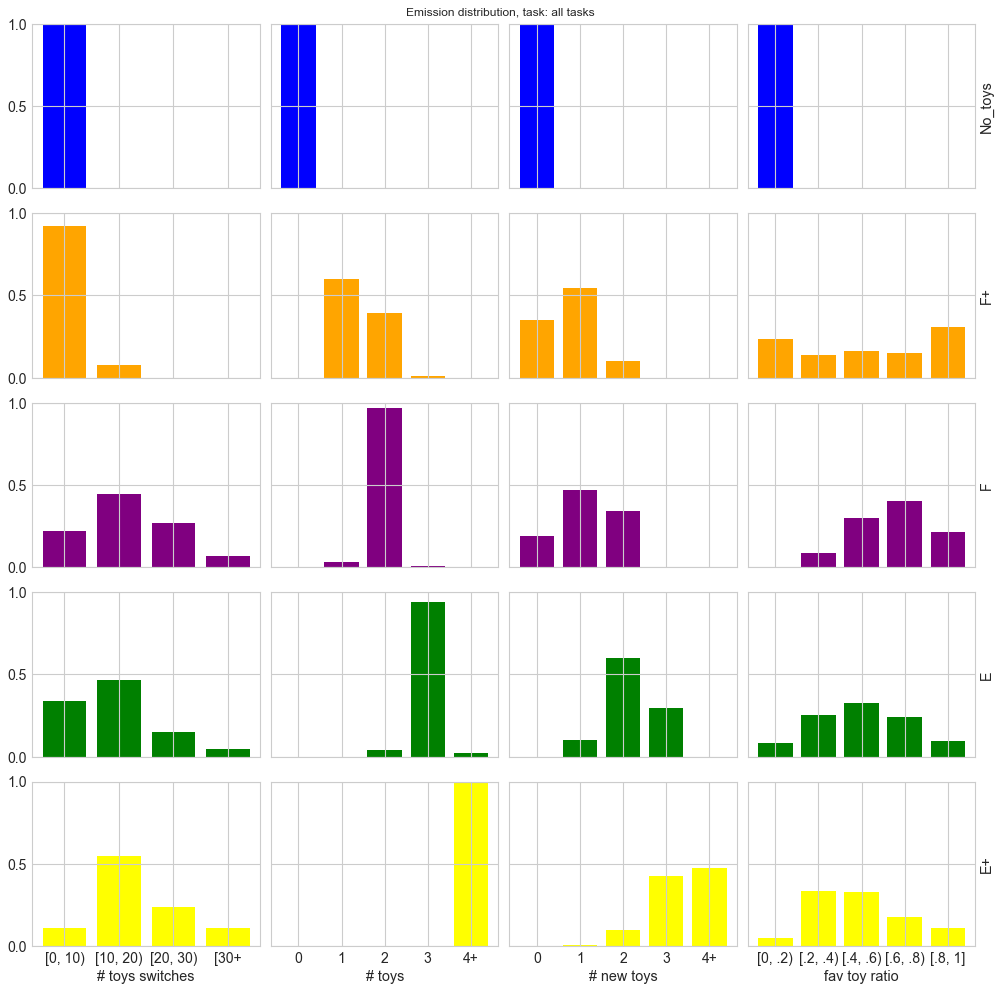

In [33]:
draw_distribution(n_features, state_name_dict, discretized_input_list, np.array(flatten_pred), "all tasks",feature_names, x_ticks_dict)

[0 1 2 3 4] [116 671 511 440 685] [0.04787454 0.27692943 0.21089558 0.18159307 0.28270739]
{0: 0.047874535699546014, 1: 0.27692942633099465, 2: 0.21089558398679323, 3: 0.18159306644655385, 4: 0.28270738753611224}


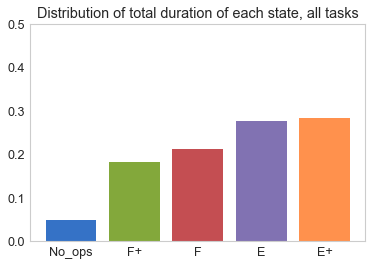

In [46]:
val, cnt = np.unique(np.array(flatten_pred).astype(int), return_counts = True)
pct = cnt/cnt.sum()

print(val, cnt, pct)

task_state_pct = {v: pct[idx] for idx, v in enumerate(val)}
for i in range(n_states):
    if i not in task_state_pct.keys():
        task_state_pct[i] = 0
print(task_state_pct)

for idx, state in enumerate(list(state_name_dict.keys())):
    plt.bar(idx, task_state_pct[state])
# plt.hist(np.array(flatten_pred_dict[task]).astype(int))
plt.xticks([0,1,2,3,4], ["No_ops", "F+", "F", "E", "E+"])
plt.ylim(top = .5)
plt.grid(b=None)
plt.title("Distribution of total duration of each state, all tasks")
plt.show()

[0 1 2 3 4] [  1 185 227 101  80] [0.0016835  0.31144781 0.38215488 0.17003367 0.13468013]


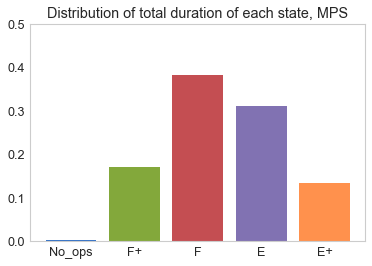

In [45]:
task = "MPS"
val, cnt = np.unique(np.array(flatten_pred_dict[task]).astype(int), return_counts = True)
pct = cnt/cnt.sum()
print(val, cnt, pct)

task_state_pct = {v: pct[idx] for idx, v in enumerate(val)}
for i in range(n_states):
    if i not in task_state_pct.keys():
        task_state_pct[i] = 0
for idx, state in enumerate(list(state_name_dict.keys())):
    plt.bar(idx, task_state_pct[state])
# plt.hist(np.array(flatten_pred_dict[task]).astype(int))
plt.ylim(top = .5)
plt.grid(b=None)

plt.xticks([0,1,2,3,4], ["No_ops", "F+", "F", "E", "E+"])
plt.title("Distribution of total duration of each state, MPS")
plt.show()

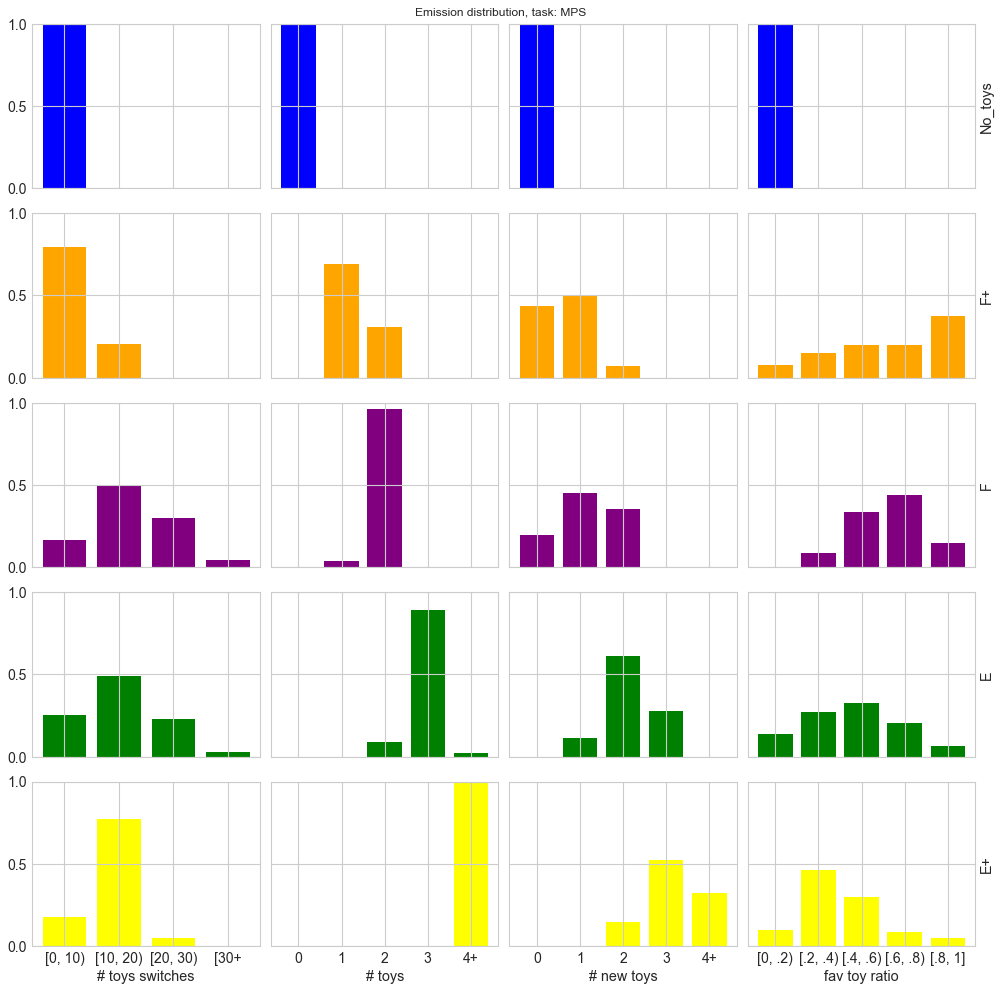

In [35]:
task = "MPS"
draw_distribution(n_features, state_name_dict, task_specific_input_dict[task], np.array(flatten_pred_dict[task]), task,feature_names, x_ticks_dict)


In [76]:
task_state_pct

{0: 0.2684563758389262,
 1: 0.18456375838926176,
 2: 0.06879194630872483,
 3: 0.47818791946308725}

[1 2 3 4] [160 110  41 285]
{1: 0.2684563758389262, 2: 0.18456375838926176, 3: 0.06879194630872483, 4: 0.47818791946308725, 0: 0}


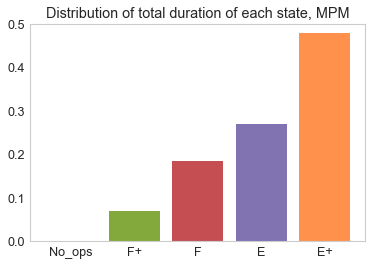

In [44]:
task = "MPM"
val, cnt = np.unique(np.array(flatten_pred_dict[task]).astype(int), return_counts = True)
pct = cnt/cnt.sum()
print(val, cnt)
task_state_pct = {v: pct[idx] for idx, v in enumerate(val)}
for i in range(n_states):
    if i not in task_state_pct.keys():
        task_state_pct[i] = 0
print(task_state_pct)
# task_state_pct[4] = 0
for idx, state in enumerate(list(state_name_dict.keys())):
    plt.bar(idx, task_state_pct[state])
# plt.hist(np.array(flatten_pred_dict[task]).astype(int))
plt.xticks([0,1,2,3,4], ["No_ops", "F+", "F", "E", "E+"])
plt.ylim(top = .5)
plt.grid(b=None)

plt.title("Distribution of total duration of each state, MPM")
plt.show()

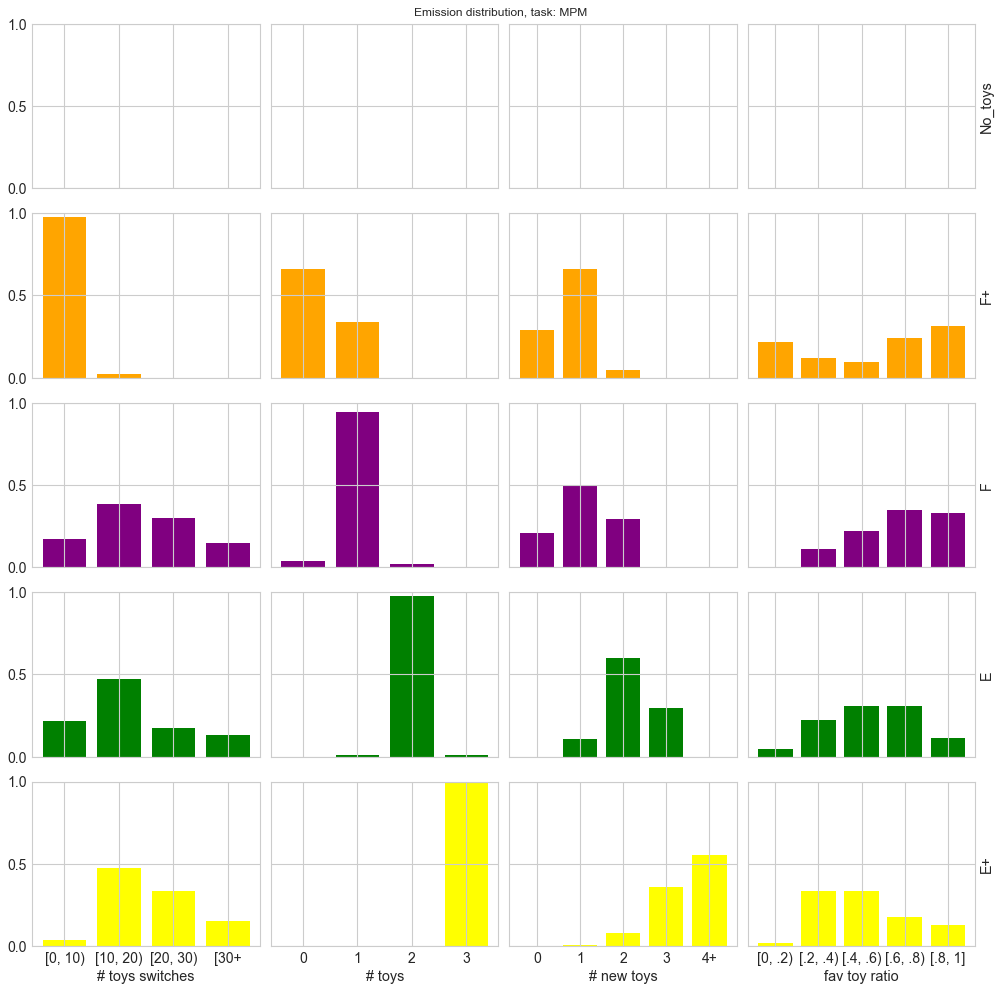

In [43]:
task = 'MPM'
draw_distribution(n_features, state_name_dict, task_specific_input_dict[task], np.array(flatten_pred_dict[task]), task,feature_names, {0: ["[0, 10)", '[10, 20)', '[20, 30)', '[30+'], 1: ['0', '1', '2', '3'], 2: ['0', '1', '2', '3', '4+'], 3: ["[0, .2)", '[.2, .4)', '[.4, .6)', '[.6, .8)', '[.8, 1]']})

[0 1 2 3 4] [ 69 172  94 206  95]
{0: 0.10849056603773585, 1: 0.27044025157232704, 2: 0.14779874213836477, 3: 0.3238993710691824, 4: 0.14937106918238993}


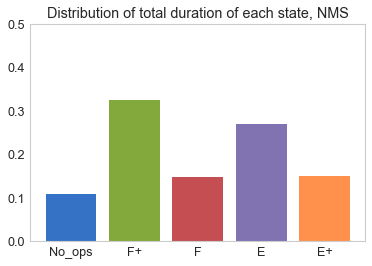

In [47]:
task = "NMS"
val, cnt = np.unique(np.array(flatten_pred_dict[task]).astype(int), return_counts = True)
pct = cnt/cnt.sum()
print(val, cnt)
task_state_pct = {v: pct[idx] for idx, v in enumerate(val)}
for i in range(n_states):
    if i not in task_state_pct.keys():
        task_state_pct[i] = 0
print(task_state_pct)
for idx, state in enumerate(list(state_name_dict.keys())):
    plt.bar(idx, task_state_pct[state])
# plt.hist(np.array(flatten_pred_dict[task]).astype(int))
plt.xticks([0,1,2,3,4], ["No_ops", "F+", "F", "E", "E+"])
plt.ylim(top = .5)
plt.grid(b=None)
plt.title("Distribution of total duration of each state, NMS")
plt.show()

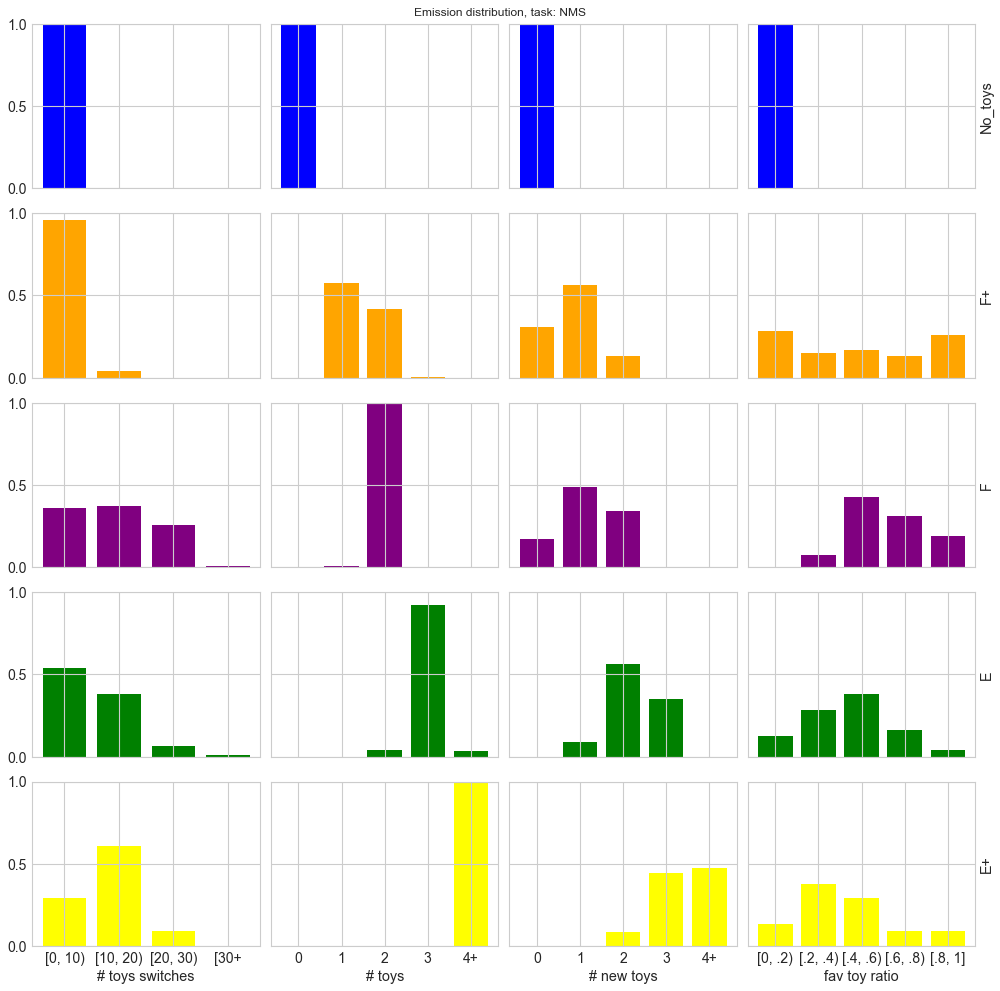

In [38]:
task = 'NMS'
draw_distribution(n_features, state_name_dict, task_specific_input_dict[task], np.array(flatten_pred_dict[task]), task,feature_names,x_ticks_dict )

[0 1 2 3 4] [ 46 154  80  92 225]


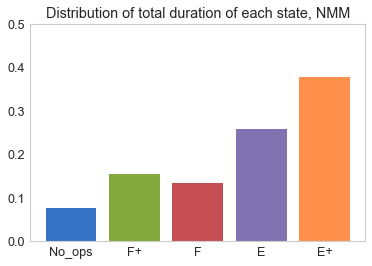

In [48]:
task = "NMM"

val, cnt = np.unique(np.array(flatten_pred_dict[task]).astype(int), return_counts = True)
pct = cnt/cnt.sum()

print(val, cnt)
task_state_pct = {v: pct[idx] for idx, v in enumerate(val)}
for i in range(n_states):
    if i not in task_state_pct.keys():
        task_state_pct[i] = 0
for idx, state in enumerate(list(state_name_dict.keys())):
    plt.bar(idx, task_state_pct[state])
# plt.hist(np.array(flatten_pred_dict[task]).astype(int))
plt.xticks([0,1,2,3,4], ["No_ops", "F+", "F", "E", "E+"])
plt.ylim(top = .5)
plt.grid(b=None)
plt.title("Distribution of total duration of each state, NMM")
plt.show()

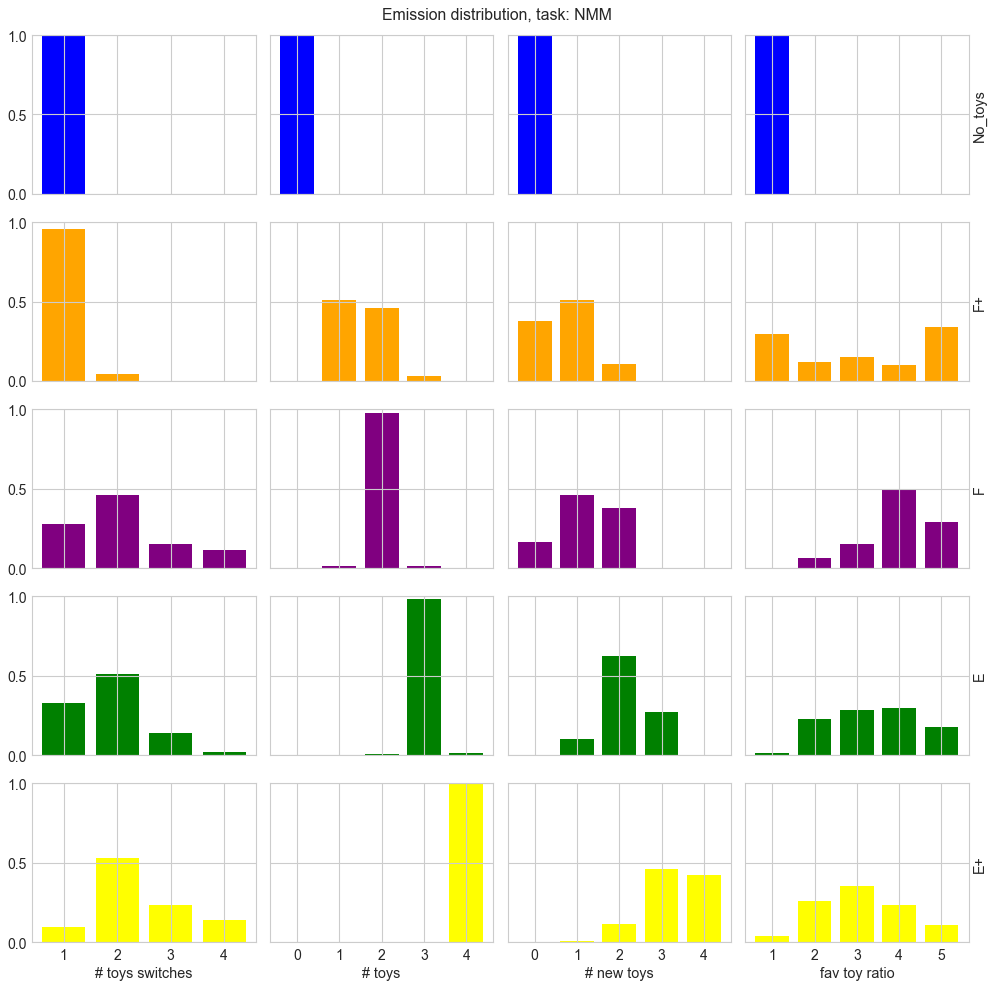

In [61]:
task = 'NMM'
draw_distribution(n_features, state_name_dict, task_specific_input_dict[task], np.array(flatten_pred_dict[task]), task,feature_names)

### Correlation between features

In [60]:
all_feature_df = pd.DataFrame(data = {'n_of_toy_switches':input_list[:,0], 'n_toys': input_list[:,1], "n_new_toys": input_list[:,2], 'fav_toy_duration': input_list[:,3], "prediction": flatten_pred})
all_feature_df['prediction'] = all_feature_df['prediction'].replace(state_name_dict)

fig = px.scatter_3d(all_feature_df, x='n_of_toy_switches', y='n_new_toys', z='fav_toy_duration',
              color='prediction')
fig.show()

In [61]:
fig = px.scatter_3d(all_feature_df, x='n_of_toy_switches', y='n_toys', z='fav_toy_duration',
              color='prediction')
fig.show()

In [77]:
print(np.corrcoef(np.hstack((all_feature_df['n_of_toy_switches'].to_numpy().reshape((-1,1)),\
            all_feature_df['n_toys'].to_numpy().reshape((-1,1)))), rowvar = False))

fig = px.scatter(all_feature_df, x = 'n_of_toy_switches', y = 'n_toys',\
            color = 'prediction')
fig.show()

[[1.         0.47004583]
 [0.47004583 1.        ]]


In [78]:
print(np.corrcoef(np.hstack((all_feature_df['n_of_toy_switches'].to_numpy().reshape((-1,1)),\
            all_feature_df['n_new_toys'].to_numpy().reshape((-1,1)))), rowvar = False))

fig = px.scatter(all_feature_df, x = 'n_of_toy_switches', y = 'n_new_toys',\
            color = 'prediction')
fig.show()

[[1.         0.38280023]
 [0.38280023 1.        ]]


In [79]:
print(np.corrcoef(np.hstack((all_feature_df['n_of_toy_switches'].to_numpy().reshape((-1,1)),\
            all_feature_df['fav_toy_duration'].to_numpy().reshape((-1,1)))), rowvar = False))

fig = px.scatter(all_feature_df, x = 'n_of_toy_switches', y = 'fav_toy_duration',\
            color = 'prediction')
fig.show()

[[1.         0.18745557]
 [0.18745557 1.        ]]


In [80]:
print(np.corrcoef(np.hstack((all_feature_df['n_toys'].to_numpy().reshape((-1,1)),\
            all_feature_df['n_new_toys'].to_numpy().reshape((-1,1)))), rowvar = False))

fig = px.scatter(all_feature_df, x = 'n_toys', y = 'n_new_toys',\
            color = 'prediction')
fig.show()

[[1.         0.87531867]
 [0.87531867 1.        ]]


In [81]:
print(np.corrcoef(np.hstack((all_feature_df['n_toys'].to_numpy().reshape((-1,1)),\
            all_feature_df['fav_toy_duration'].to_numpy().reshape((-1,1)))), rowvar = False))

fig = px.scatter(all_feature_df, x = 'n_toys', y = 'fav_toy_duration',\
            color = 'prediction')
fig.show()

[[1.         0.08885846]
 [0.08885846 1.        ]]


In [82]:
print(np.corrcoef(np.hstack((all_feature_df['n_new_toys'].to_numpy().reshape((-1,1)),\
            all_feature_df['fav_toy_duration'].to_numpy().reshape((-1,1)))), rowvar = False))

fig = px.scatter(all_feature_df, x = 'n_new_toys', y = 'fav_toy_duration',\
            color = 'prediction')
fig.show()

[[ 1.         -0.08316515]
 [-0.08316515  1.        ]]


### Timeline of infants at each states

In [2]:
with open('../data/interim/20210709_5_states_merged_prediction.pickle', 'rb') as f:
    merged_pred_dict_all = pickle.load(f)

In [3]:
def get_longest_item(dictionary):
    return max((len(v)) for _,v in dictionary.items())

In [37]:
print(get_longest_item(merged_pred_dict_all[task]))

22


In [6]:
cnt_dict_task_specific = {}
for task in tasks:
    cnt_dict_task_specific[task] = {}
    len_ = get_longest_item(merged_pred_dict_all[task])
    for i in range(n_states):
        cnt_dict_task_specific[task][i] = [0]*len_

In [7]:
for task in tasks:
    for subj, state_list in merged_pred_dict_all[task].items():
        for idx, state in enumerate(state_list):

            cnt_dict_task_specific[task][state][idx] += 1
    

In [29]:
def draw_infant_each_min_matplotlib(focus_cnt: list, explore_cnt: list, no_ops_state: list):
    x = np.arange(17)
    tickvals = [x for x in range(17) if x % 2 ==0]
    ticktext = [str(int(x/2)) for x in tickvals]
    x_labels = []
    fig, ax = plt.subplots()#figure(figsize=(6,4))
    explore_plot, = ax.plot(x, explore_cnt[:17], marker = 'v', color = 'green', label = 'Explore states: E, E+')
    focus_plot, = ax.plot(x, focus_cnt[:17], marker = 'o', color = 'orange', label = 'Focus states: F, F+')
    no_ops_plot, = ax.plot(x, no_ops_state[:17], marker = 'h', color = 'blue', label = 'No_ops')


    ax.legend(handles=[explore_plot, focus_plot, no_ops_plot], bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel('Minutes')
    ax.set_ylabel('Number of infant')
    # ax.set_yticks(np.arange(0, 20, 2))
    ax.set_xticks(np.arange(0, 17, 2))

    ax.set_xticklabels([str(x) for x in np.arange(0,len(ticktext),1)])

    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % 2 != 0]

    plt.show()

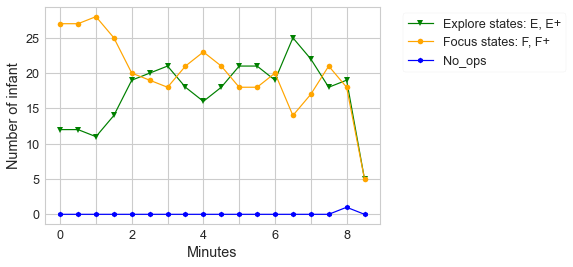

In [20]:
task =  "MPS"
focus_state = np.array(cnt_dict_task_specific[task][3]) + np.array(cnt_dict_task_specific[task][2]) 
explore_state = np.array(cnt_dict_task_specific[task][1]) + np.array(cnt_dict_task_specific[task][4]) 
draw_infant_each_min_matplotlib(focus_state, explore_state, cnt_dict_task_specific[task][0])


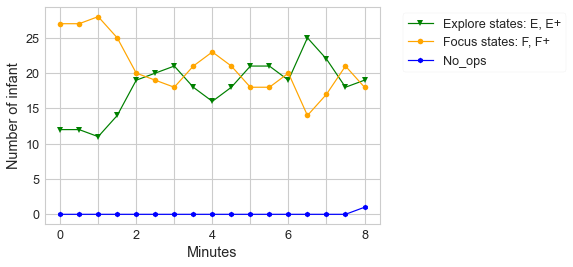

In [22]:
task =  "MPS"
focus_state = np.array(cnt_dict_task_specific[task][3]) + np.array(cnt_dict_task_specific[task][2]) 
explore_state = np.array(cnt_dict_task_specific[task][1]) + np.array(cnt_dict_task_specific[task][4]) 
draw_infant_each_min_matplotlib(focus_state, explore_state, cnt_dict_task_specific[task][0])



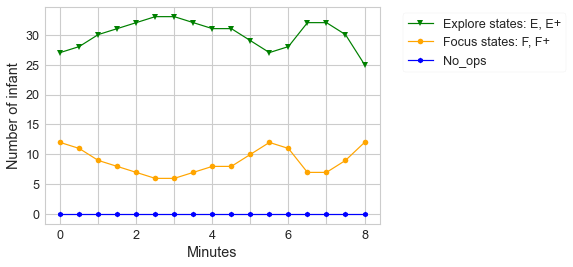

In [25]:
task =  "MPM"
focus_state = np.array(cnt_dict_task_specific[task][3]) + np.array(cnt_dict_task_specific[task][2]) 
explore_state = np.array(cnt_dict_task_specific[task][1]) + np.array(cnt_dict_task_specific[task][4]) 
draw_infant_each_min_matplotlib(focus_state, explore_state, cnt_dict_task_specific[task][0])


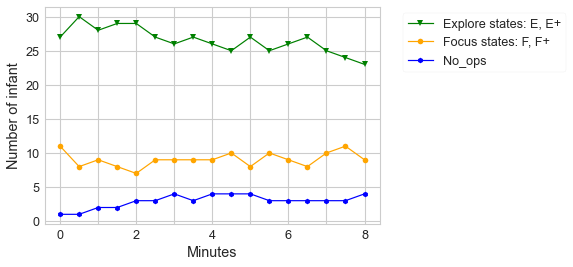

In [30]:
task =  "NMM"
focus_state = np.array(cnt_dict_task_specific[task][3]) + np.array(cnt_dict_task_specific[task][2]) 
explore_state = np.array(cnt_dict_task_specific[task][1]) + np.array(cnt_dict_task_specific[task][4]) 
draw_infant_each_min_matplotlib(focus_state, explore_state, cnt_dict_task_specific[task][0])


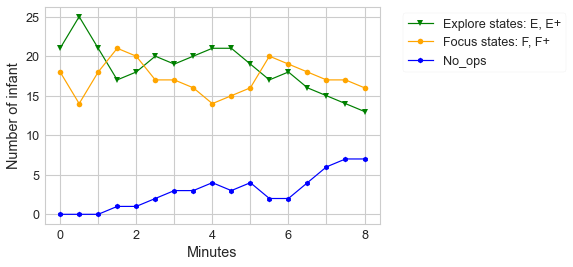

In [31]:
task =  "NMS"
focus_state = np.array(cnt_dict_task_specific[task][3]) + np.array(cnt_dict_task_specific[task][2]) 
explore_state = np.array(cnt_dict_task_specific[task][1]) + np.array(cnt_dict_task_specific[task][4]) 
draw_infant_each_min_matplotlib(focus_state, explore_state, cnt_dict_task_specific[task][0])
